# Model sieci - 4 gatunki, normalne spectrogramy

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Path to the spectrogram folders
train_dir = r'D:\sieci_neuronowe\projekt-sieci-neuronowe\Spectro_4gen'
test_dir = r'D:\sieci_neuronowe\projekt-sieci-neuronowe\Spectro_4gen_test'
folders = ['Anser_anser', 'Dendrocopos_major', 'Parsed_Capuchinbird', 'Parus_major']

# Constants
img_width, img_height = 223, 217
batch_size = 32
epochs = 50  # Increased epochs

# Load spectrograms and preprocess with data augmentation for training data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

# Preprocess only for validation data
test_datagen = ImageDataGenerator(rescale=1./255)

# Training data generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

# Validation data generator
validation_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

# Define CNN architecture
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),  # Added dropout
    Dense(len(folders), activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    callbacks=[early_stopping, reduce_lr])

# Plot training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(validation_generator, steps=validation_generator.samples // batch_size)
print(f'Test accuracy: {test_acc:.2f}')

# Save the model
model.save('bird_species_cnn_model_4genres.h5')

# Test sieci - 4 gatunki

1/1 [==============================] - 0s 76ms/step
Overall Accuracy: 99.75%


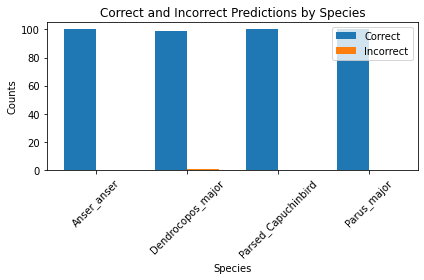

C:\Users\Filip\AppData\Local\Temp\ipykernel_20360\641537264.py:121: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(species, rotation=45)


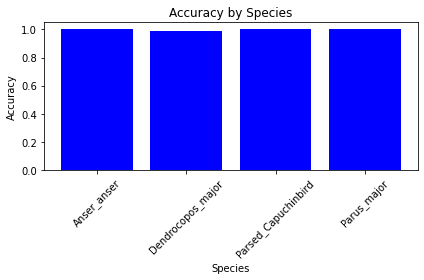

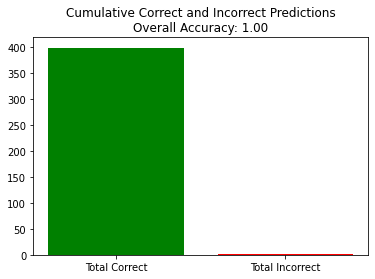

In [12]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

# Path to the trained model
model_path = 'bird_species_cnn_model_4genres.h5'

# Load the trained model once
model = load_model(model_path)

# Function to load and preprocess an image
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(223, 217))  # Zaktualizuj rozmiar obrazu
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Skalowanie obrazu
    return img_array

# Function to predict the species
def predict_species(img_path):
    # Preprocess the image
    img_array = preprocess_image(img_path)

    # Make prediction
    prediction = model.predict(img_array)
    
    # Get the predicted class label
    predicted_class_index = np.argmax(prediction)
    
    # Map class index to species name
    species_mapping = {
        0: 'Anser_anser', 1: 'Dendrocopos_major', 2: 'Parsed_Capuchinbird', 3: 'Parus_major',
    }
    predicted_species = species_mapping[predicted_class_index]

    return predicted_species

# Paths to the spectrogram folders
base_dir = r'D:\sieci_neuronowe\projekt-sieci-neuronowe\Spectro_4gen'
folders = ['Anser_anser', 'Dendrocopos_major', 'Parsed_Capuchinbird', 'Parus_major']
results = {}




# For each folder (species), select 100 random spectrograms and validate predictions
for folder in folders:
    folder_path = os.path.join(base_dir, folder)
    spectrogram_files = os.listdir(folder_path)
    
    # Ensure there are at least 100 files in the folder
    if len(spectrogram_files) < 100:
        print(f"Folder {folder} does not contain 100 images.")
        continue
    
    selected_files = random.sample(spectrogram_files, 100)
    correct_predictions = 0
    incorrect_predictions = 0
    
    for file in selected_files:
        spectrogram_path = os.path.join(folder_path, file)
        
        # Predict species
        predicted_species = predict_species(spectrogram_path)
        
        # Extract true species from folder name
        true_species = folder
        
        # Compare prediction with true species
        if predicted_species == true_species:
            correct_predictions += 1
        else:
            incorrect_predictions += 1

    results[folder] = {
        'correct': correct_predictions,
        'incorrect': incorrect_predictions,
        'accuracy': correct_predictions / 100  # 100 samples per folder
    }

# Calculate overall accuracy
total_correct = sum(results[sp]['correct'] for sp in folders)
total_incorrect = sum(results[sp]['incorrect'] for sp in folders)
overall_accuracy = total_correct / (total_correct + total_incorrect)

print(f"Overall Accuracy: {overall_accuracy * 100:.2f}%")

# Plot bar chart for each species
species = list(results.keys())
correct_counts = [results[sp]['correct'] for sp in species]
incorrect_counts = [results[sp]['incorrect'] for sp in species]
accuracies = [results[sp]['accuracy'] for sp in species]

x = np.arange(len(species))
width = 0.35

fig, ax1 = plt.subplots()
rects1 = ax1.bar(x - width/2, correct_counts, width, label='Correct')
rects2 = ax1.bar(x + width/2, incorrect_counts, width, label='Incorrect')

ax1.set_xlabel('Species')
ax1.set_ylabel('Counts')
ax1.set_title('Correct and Incorrect Predictions by Species')
ax1.set_xticks(x)
ax1.set_xticklabels(species, rotation=45)
ax1.legend()

fig.tight_layout()
plt.show()

# Plot accuracy for each species
fig, ax2 = plt.subplots()
rects3 = ax2.bar(species, accuracies, color='blue')

ax2.set_xlabel('Species')
ax2.set_ylabel('Accuracy')
ax2.set_title('Accuracy by Species')
ax2.set_xticklabels(species, rotation=45)

fig.tight_layout()
plt.show()

# Plot cumulative bar chart
fig, ax3 = plt.subplots()
ax3.bar(['Total Correct', 'Total Incorrect'], [total_correct, total_incorrect], color=['green', 'red'])
ax3.set_title(f'Cumulative Correct and Incorrect Predictions\nOverall Accuracy: {overall_accuracy:.2f}')

plt.show()

# Wizualizacja danych

1/1 [==============================] - 0s 80ms/step


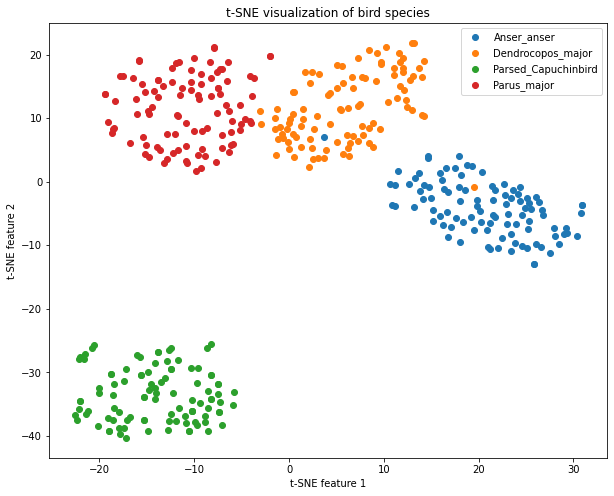

In [13]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.preprocessing import image
from sklearn.manifold import TSNE

# Path to the trained model
model_path = 'bird_species_cnn_model_4genres.h5'

# Load the trained model once
model = load_model(model_path)

def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(223, 217))  # Zaktualizuj rozmiar obrazu
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Skalowanie obrazu
    return img_array

# Extract features from the 'dense' layer (assuming this is the second to last layer)
layer_name = 'dense_6'  # Zaktualizuj nazwę warstwy w zależności od modelu
intermediate_layer_model = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)

# Function to extract features
def extract_features(img_path):
    img_array = preprocess_image(img_path)
    features = intermediate_layer_model.predict(img_array)
    return features.flatten()

# Paths to the spectrogram folders
base_dir = r'D:\sieci_neuronowe\projekt-sieci-neuronowe\Spectro_4gen'
folders = ['Anser_anser', 'Dendrocopos_major', 'Parsed_Capuchinbird', 'Parus_major']
results = {}
features = []
labels = []

for folder in folders:
    folder_path = os.path.join(base_dir, folder)
    spectrogram_files = os.listdir(folder_path)
    
    # Select 100 random spectrograms
    if len(spectrogram_files) < 100:
        print(f"Folder {folder} does not contain 100 images.")
        continue
    
    selected_files = random.sample(spectrogram_files, 100)
    
    for file in selected_files:
        spectrogram_path = os.path.join(folder_path, file)
        features.append(extract_features(spectrogram_path))
        labels.append(folder)

# Convert to numpy arrays
features = np.array(features)
labels = np.array(labels)

# Reduce dimensionality using t-SNE
tsne = TSNE(n_components=2, random_state=0)
features_2d = tsne.fit_transform(features)

# Plot t-SNE
plt.figure(figsize=(10, 8))
for species in np.unique(labels):
    indices = labels == species
    plt.scatter(features_2d[indices, 0], features_2d[indices, 1], label=species)

plt.legend()
plt.title('t-SNE visualization of bird species')
plt.xlabel('t-SNE feature 1')
plt.ylabel('t-SNE feature 2')
plt.show()


# Model sieci - 4 gatunki, spektrogramy Mela

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Path to the spectrogram folders
train_dir = r'D:\sieci_neuronowe\projekt-sieci-neuronowe\mel_4gen'
test_dir = r'D:\sieci_neuronowe\projekt-sieci-neuronowe\mel_4gen_test'
folders = ['Anser_anser', 'Dendrocopos_major', 'Parsed_Capuchinbird', 'Parus_major']

# Constants
img_width, img_height = 223, 217
batch_size = 32
epochs = 20  # Increased epochs

# Load spectrograms and preprocess with data augmentation for training data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

# Preprocess only for validation data
test_datagen = ImageDataGenerator(rescale=1./255)

# Training data generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

# Validation data generator
validation_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

# Define CNN architecture
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),  # Added dropout
    Dense(len(folders), activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    callbacks=[early_stopping, reduce_lr])

# Plot training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(validation_generator, steps=validation_generator.samples // batch_size)
print(f'Test accuracy: {test_acc:.2f}')

# Save the model
model.save('bird_species_cnn_model_4genres_mel.h5')

# Test sieci - 4 gatunki i spektrogramy Mela

1/1 [==============================] - 0s 37ms/step
Overall Accuracy: 100.00%


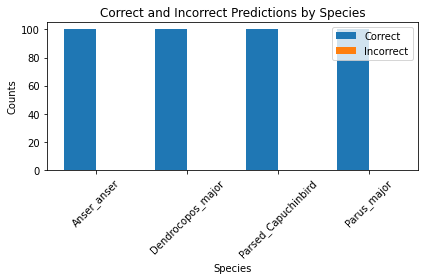

C:\Users\Filip\AppData\Local\Temp\ipykernel_20360\2722569896.py:120: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(species, rotation=45)


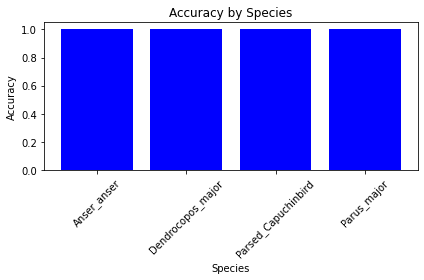

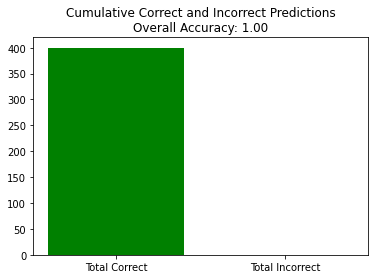

In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

# Path to the trained model
model_path = 'bird_species_cnn_model_4genres_mel.h5'

# Load the trained model once
model = load_model(model_path)

# Function to load and preprocess an image
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(223, 217))  # Zaktualizuj rozmiar obrazu
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Skalowanie obrazu
    return img_array

# Function to predict the species
def predict_species(img_path):
    # Preprocess the image
    img_array = preprocess_image(img_path)

    # Make prediction
    prediction = model.predict(img_array)
    
    # Get the predicted class label
    predicted_class_index = np.argmax(prediction)
    
    # Map class index to species name
    species_mapping = {
        0: 'Anser_anser', 1: 'Dendrocopos_major', 2: 'Parsed_Capuchinbird', 3: 'Parus_major',
    }
    predicted_species = species_mapping[predicted_class_index]

    return predicted_species

# Paths to the spectrogram folders
base_dir = r'D:\sieci_neuronowe\projekt-sieci-neuronowe\mel_4gen'
folders = ['Anser_anser', 'Dendrocopos_major', 'Parsed_Capuchinbird', 'Parus_major']
results = {}

results = {}

# For each folder (species), select 100 random spectrograms and validate predictions
for folder in folders:
    folder_path = os.path.join(base_dir, folder)
    spectrogram_files = os.listdir(folder_path)
    
    # Ensure there are at least 100 files in the folder
    if len(spectrogram_files) < 100:
        print(f"Folder {folder} does not contain 100 images.")
        continue
    
    selected_files = random.sample(spectrogram_files, 100)
    correct_predictions = 0
    incorrect_predictions = 0
    
    for file in selected_files:
        spectrogram_path = os.path.join(folder_path, file)
        
        # Predict species
        predicted_species = predict_species(spectrogram_path)
        
        # Extract true species from folder name
        true_species = folder
        
        # Compare prediction with true species
        if predicted_species == true_species:
            correct_predictions += 1
        else:
            incorrect_predictions += 1

    results[folder] = {
        'correct': correct_predictions,
        'incorrect': incorrect_predictions,
        'accuracy': correct_predictions / 100  # 100 samples per folder
    }

# Calculate overall accuracy
total_correct = sum(results[sp]['correct'] for sp in folders)
total_incorrect = sum(results[sp]['incorrect'] for sp in folders)
overall_accuracy = total_correct / (total_correct + total_incorrect)

print(f"Overall Accuracy: {overall_accuracy * 100:.2f}%")

# Plot bar chart for each species
species = list(results.keys())
correct_counts = [results[sp]['correct'] for sp in species]
incorrect_counts = [results[sp]['incorrect'] for sp in species]
accuracies = [results[sp]['accuracy'] for sp in species]

x = np.arange(len(species))
width = 0.35

fig, ax1 = plt.subplots()
rects1 = ax1.bar(x - width/2, correct_counts, width, label='Correct')
rects2 = ax1.bar(x + width/2, incorrect_counts, width, label='Incorrect')

ax1.set_xlabel('Species')
ax1.set_ylabel('Counts')
ax1.set_title('Correct and Incorrect Predictions by Species')
ax1.set_xticks(x)
ax1.set_xticklabels(species, rotation=45)
ax1.legend()

fig.tight_layout()
plt.show()

# Plot accuracy for each species
fig, ax2 = plt.subplots()
rects3 = ax2.bar(species, accuracies, color='blue')

ax2.set_xlabel('Species')
ax2.set_ylabel('Accuracy')
ax2.set_title('Accuracy by Species')
ax2.set_xticklabels(species, rotation=45)

fig.tight_layout()
plt.show()

# Plot cumulative bar chart
fig, ax3 = plt.subplots()
ax3.bar(['Total Correct', 'Total Incorrect'], [total_correct, total_incorrect], color=['green', 'red'])
ax3.set_title(f'Cumulative Correct and Incorrect Predictions\nOverall Accuracy: {overall_accuracy:.2f}')

plt.show()

# Wizualizacja danych

1/1 [==============================] - 0s 44ms/step


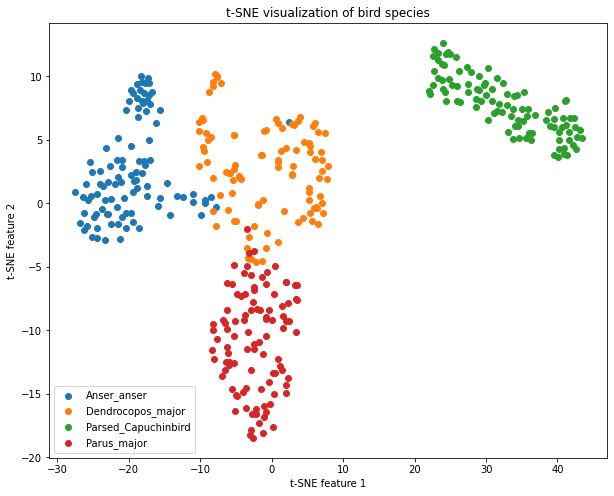

In [9]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.preprocessing import image
from sklearn.manifold import TSNE

# Path to the trained model
model_path = 'bird_species_cnn_model_4genres_mel.h5'

# Load the trained model once
model = load_model(model_path)

def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(223, 217))  # Zaktualizuj rozmiar obrazu
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Skalowanie obrazu
    return img_array

# Extract features from the 'dense' layer (assuming this is the second to last layer)
layer_name = 'dense_4'  # Zaktualizuj nazwę warstwy w zależności od modelu
intermediate_layer_model = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)

# Function to extract features
def extract_features(img_path):
    img_array = preprocess_image(img_path)
    features = intermediate_layer_model.predict(img_array)
    return features.flatten()

# Paths to the spectrogram folders
base_dir = r'D:\sieci_neuronowe\projekt-sieci-neuronowe\mel_spectrograms'
folders = ['Anser_anser', 'Dendrocopos_major', 'Parsed_Capuchinbird', 'Parus_major']
results = {}
features = []
labels = []

for folder in folders:
    folder_path = os.path.join(base_dir, folder)
    spectrogram_files = os.listdir(folder_path)
    
    # Select 100 random spectrograms
    if len(spectrogram_files) < 100:
        print(f"Folder {folder} does not contain 100 images.")
        continue
    
    selected_files = random.sample(spectrogram_files, 100)
    
    for file in selected_files:
        spectrogram_path = os.path.join(folder_path, file)
        features.append(extract_features(spectrogram_path))
        labels.append(folder)

# Convert to numpy arrays
features = np.array(features)
labels = np.array(labels)

# Reduce dimensionality using t-SNE
tsne = TSNE(n_components=2, random_state=0)
features_2d = tsne.fit_transform(features)

# Plot t-SNE
plt.figure(figsize=(10, 8))
for species in np.unique(labels):
    indices = labels == species
    plt.scatter(features_2d[indices, 0], features_2d[indices, 1], label=species)

plt.legend()
plt.title('t-SNE visualization of bird species')
plt.xlabel('t-SNE feature 1')
plt.ylabel('t-SNE feature 2')
plt.show()


# Model sieci - 8 gatunków, normalne histogramy

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Path to the spectrogram folders
train_dir = r'D:\sieci_neuronowe\projekt-sieci-neuronowe\Spectro_v2'
test_dir = r'D:\sieci_neuronowe\projekt-sieci-neuronowe\Spectro_v2_test'
folders = ['Anser_anser', 'Dendrocopos_major', 'Parsed_Capuchinbird', 'Parus_major', 'Himantopushimantopus',  'Athenenoctua', 'Phasianus_colchicus', 'Corvuscornix']

# Constants
img_width, img_height = 223, 217
batch_size = 32
epochs = 20  # Increased epochs for better training

# Load spectrograms and preprocess with data augmentation for training data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

# Preprocess only for validation data
test_datagen = ImageDataGenerator(rescale=1./255)

# Training data generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

# Validation data generator
validation_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

# Define CNN architecture
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),  # Added dropout for regularization
    Dense(len(folders), activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    callbacks=[early_stopping, reduce_lr])

# Plot training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(validation_generator, steps=validation_generator.samples // batch_size)
print(f'Test accuracy: {test_acc:.2f}')

# Save the model
model.save('bird_species_cnn_model_8genres.h5')

# Test sieci - 8 gatunków, normalne histogramy

1/1 [==============================] - 0s 36ms/step
Overall Accuracy: 98.25%


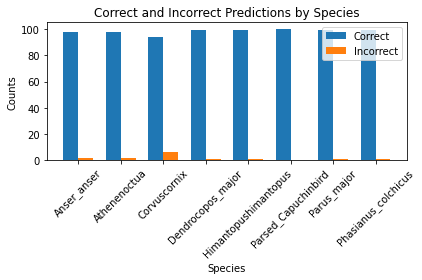

C:\Users\Filip\AppData\Local\Temp\ipykernel_20360\3867882161.py:122: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(species, rotation=45)


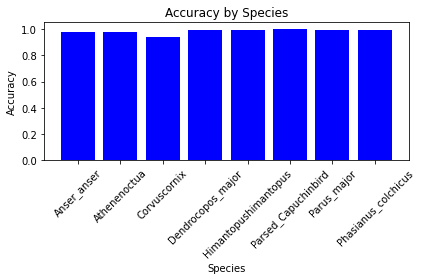

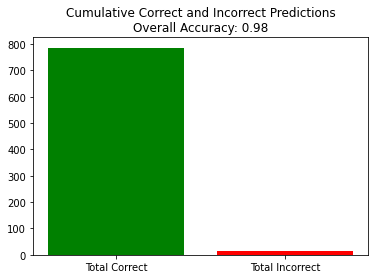

In [2]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

# Path to the trained model
model_path = 'bird_species_cnn_model_8genres.h5'

# Load the trained model once
model = load_model(model_path)

# Function to load and preprocess an image
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(223, 217))  # Zaktualizuj rozmiar obrazu
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Skalowanie obrazu
    return img_array

# Function to predict the species
def predict_species(img_path):
    # Preprocess the image
    img_array = preprocess_image(img_path)

    # Make prediction
    prediction = model.predict(img_array)
    
    # Get the predicted class label
    predicted_class_index = np.argmax(prediction)
    
    # Map class index to species name
    species_mapping = {
        0: 'Anser_anser', 1:'Athenenoctua', 2: 'Corvuscornix', 3: 'Dendrocopos_major',
        4: 'Himantopushimantopus', 5: 'Parsed_Capuchinbird' , 6: 'Parus_major', 7: 'Phasianus_colchicus'
    }
    predicted_species = species_mapping[predicted_class_index]

    return predicted_species

# Paths to the spectrogram folders
base_dir = r'D:\sieci_neuronowe\projekt-sieci-neuronowe\Spectro_v2'
folders = [ 'Anser_anser', 'Athenenoctua',  'Corvuscornix',  'Dendrocopos_major',
         'Himantopushimantopus',  'Parsed_Capuchinbird' ,  'Parus_major','Phasianus_colchicus']


results = {}

# For each folder (species), select 100 random spectrograms and validate predictions
for folder in folders:
    folder_path = os.path.join(base_dir, folder)
    spectrogram_files = os.listdir(folder_path)
    
    # Ensure there are at least 100 files in the folder
    if len(spectrogram_files) < 100:
        print(f"Folder {folder} does not contain 100 images.")
        continue
    
    selected_files = random.sample(spectrogram_files, 100)
    correct_predictions = 0
    incorrect_predictions = 0
    
    for file in selected_files:
        spectrogram_path = os.path.join(folder_path, file)
        
        # Predict species
        predicted_species = predict_species(spectrogram_path)
        
        # Extract true species from folder name
        true_species = folder
        
        # Compare prediction with true species
        if predicted_species == true_species:
            correct_predictions += 1
        else:
            incorrect_predictions += 1

    results[folder] = {
        'correct': correct_predictions,
        'incorrect': incorrect_predictions,
        'accuracy': correct_predictions / 100  # 100 samples per folder
    }

# Calculate overall accuracy
total_correct = sum(results[sp]['correct'] for sp in folders)
total_incorrect = sum(results[sp]['incorrect'] for sp in folders)
overall_accuracy = total_correct / (total_correct + total_incorrect)

print(f"Overall Accuracy: {overall_accuracy * 100:.2f}%")

# Plot bar chart for each species
species = list(results.keys())
correct_counts = [results[sp]['correct'] for sp in species]
incorrect_counts = [results[sp]['incorrect'] for sp in species]
accuracies = [results[sp]['accuracy'] for sp in species]

x = np.arange(len(species))
width = 0.35

fig, ax1 = plt.subplots()
rects1 = ax1.bar(x - width/2, correct_counts, width, label='Correct')
rects2 = ax1.bar(x + width/2, incorrect_counts, width, label='Incorrect')

ax1.set_xlabel('Species')
ax1.set_ylabel('Counts')
ax1.set_title('Correct and Incorrect Predictions by Species')
ax1.set_xticks(x)
ax1.set_xticklabels(species, rotation=45)
ax1.legend()

fig.tight_layout()
plt.show()

# Plot accuracy for each species
fig, ax2 = plt.subplots()
rects3 = ax2.bar(species, accuracies, color='blue')

ax2.set_xlabel('Species')
ax2.set_ylabel('Accuracy')
ax2.set_title('Accuracy by Species')
ax2.set_xticklabels(species, rotation=45)

fig.tight_layout()
plt.show()

# Plot cumulative bar chart
fig, ax3 = plt.subplots()
ax3.bar(['Total Correct', 'Total Incorrect'], [total_correct, total_incorrect], color=['green', 'red'])
ax3.set_title(f'Cumulative Correct and Incorrect Predictions\nOverall Accuracy: {overall_accuracy:.2f}')

plt.show()

# Wizualizacja danych

1/1 [==============================] - 0s 45ms/step


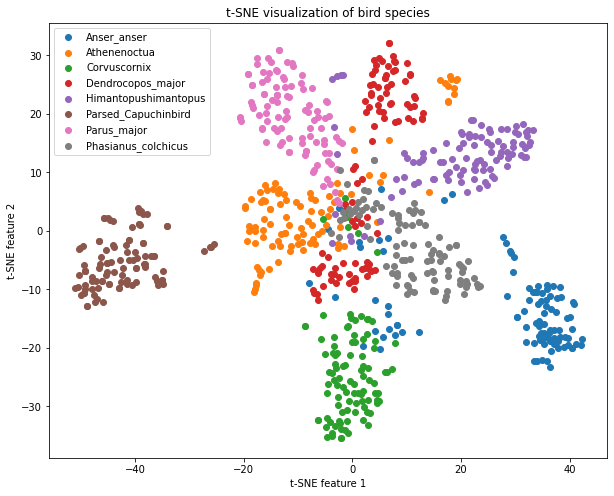

In [5]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.preprocessing import image
from sklearn.manifold import TSNE
# Path to the trained model



# Path to the trained model
model_path = 'bird_species_cnn_model_8genres.h5'

# Load the trained model once
model = load_model(model_path)

def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(223, 217))  # Zaktualizuj rozmiar obrazu
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Skalowanie obrazu
    return img_array

# Extract features from the 'dense' layer (assuming this is the second to last layer)
layer_name = 'dense_6'  # Zaktualizuj nazwę warstwy w zależności od modelu
intermediate_layer_model = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)

# Function to extract features
def extract_features(img_path):
    img_array = preprocess_image(img_path)
    features = intermediate_layer_model.predict(img_array)
    return features.flatten()

# Paths to the spectrogram folders
# Paths to the spectrogram folders
base_dir = r'D:\sieci_neuronowe\projekt-sieci-neuronowe\Spectro_v2'
folders = ['Anser_anser', 'Dendrocopos_major', 'Parsed_Capuchinbird', 'Parus_major', 'Himantopushimantopus',  'Athenenoctua', 'Phasianus_colchicus', 'Corvuscornix']

results = {}
features = []
labels = []

for folder in folders:
    folder_path = os.path.join(base_dir, folder)
    spectrogram_files = os.listdir(folder_path)
    
    # Select 100 random spectrograms
    if len(spectrogram_files) < 100:
        print(f"Folder {folder} does not contain 100 images.")
        continue
    
    selected_files = random.sample(spectrogram_files, 100)
    
    for file in selected_files:
        spectrogram_path = os.path.join(folder_path, file)
        features.append(extract_features(spectrogram_path))
        labels.append(folder)

# Convert to numpy arrays
features = np.array(features)
labels = np.array(labels)

# Reduce dimensionality using t-SNE
tsne = TSNE(n_components=2, random_state=0)
features_2d = tsne.fit_transform(features)

# Plot t-SNE
plt.figure(figsize=(10, 8))
for species in np.unique(labels):
    indices = labels == species
    plt.scatter(features_2d[indices, 0], features_2d[indices, 1], label=species)

plt.legend()
plt.title('t-SNE visualization of bird species')
plt.xlabel('t-SNE feature 1')
plt.ylabel('t-SNE feature 2')
plt.show()


# Model sieci - 8 gatunków, histogramy mela

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Path to the spectrogram folders
train_dir = r'D:\sieci_neuronowe\projekt-sieci-neuronowe\mel_v2'
test_dir = r'D:\sieci_neuronowe\projekt-sieci-neuronowe\mel_v2_test'
folders = ['Anser_anser', 'Dendrocopos_major', 'Parsed_Capuchinbird', 'Parus_major', 'Himantopushimantopus',  'Athenenoctua', 'Phasianus_colchicus', 'Corvuscornix']

# Constants
img_width, img_height = 223, 217
batch_size = 32
epochs = 20  # Increased epochs for better training

# Load spectrograms and preprocess with data augmentation for training data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

# Preprocess only for validation data
test_datagen = ImageDataGenerator(rescale=1./255)

# Training data generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

# Validation data generator
validation_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

# Define CNN architecture
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),  # Added dropout for regularization
    Dense(len(folders), activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    callbacks=[early_stopping, reduce_lr])

# Plot training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(validation_generator, steps=validation_generator.samples // batch_size)
print(f'Test accuracy: {test_acc:.2f}')

# Save the model
model.save('bird_species_cnn_model_8genres_mel.h5')  # Opcjonalnie zmień nazwę pliku



# Test sieci

1/1 [==============================] - 0s 45ms/step
Overall Accuracy: 98.50%


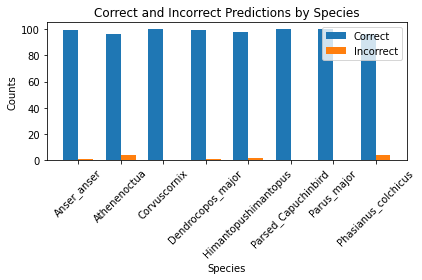

C:\Users\Filip\AppData\Local\Temp\ipykernel_20360\3315224532.py:122: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(species, rotation=45)


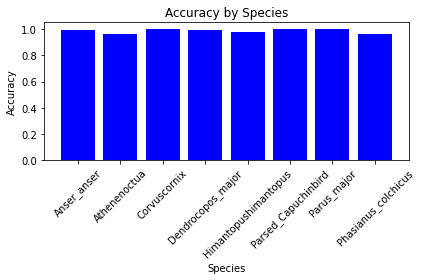

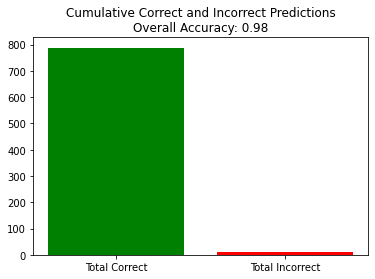

In [6]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

# Path to the trained model
model_path = 'bird_species_cnn_model_8genres_mel.h5'

# Load the trained model once
model = load_model(model_path)

# Function to load and preprocess an image
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(223, 217))  # Zaktualizuj rozmiar obrazu
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Skalowanie obrazu
    return img_array

# Function to predict the species
def predict_species(img_path):
    # Preprocess the image
    img_array = preprocess_image(img_path)

    # Make prediction
    prediction = model.predict(img_array)
    
    # Get the predicted class label
    predicted_class_index = np.argmax(prediction)
    
    # Map class index to species name
    species_mapping = {
        0: 'Anser_anser', 1:'Athenenoctua', 2: 'Corvuscornix', 3: 'Dendrocopos_major',
        4: 'Himantopushimantopus', 5: 'Parsed_Capuchinbird' , 6: 'Parus_major', 7: 'Phasianus_colchicus'
    }
    predicted_species = species_mapping[predicted_class_index]

    return predicted_species

# Paths to the spectrogram folders
base_dir = r'D:\sieci_neuronowe\projekt-sieci-neuronowe\mel_v2'
folders = [ 'Anser_anser', 'Athenenoctua',  'Corvuscornix',  'Dendrocopos_major',
         'Himantopushimantopus',  'Parsed_Capuchinbird' ,  'Parus_major','Phasianus_colchicus']


results = {}

# For each folder (species), select 100 random spectrograms and validate predictions
for folder in folders:
    folder_path = os.path.join(base_dir, folder)
    spectrogram_files = os.listdir(folder_path)
    
    # Ensure there are at least 100 files in the folder
    if len(spectrogram_files) < 100:
        print(f"Folder {folder} does not contain 100 images.")
        continue
    
    selected_files = random.sample(spectrogram_files, 100)
    correct_predictions = 0
    incorrect_predictions = 0
    
    for file in selected_files:
        spectrogram_path = os.path.join(folder_path, file)
        
        # Predict species
        predicted_species = predict_species(spectrogram_path)
        
        # Extract true species from folder name
        true_species = folder
        
        # Compare prediction with true species
        if predicted_species == true_species:
            correct_predictions += 1
        else:
            incorrect_predictions += 1

    results[folder] = {
        'correct': correct_predictions,
        'incorrect': incorrect_predictions,
        'accuracy': correct_predictions / 100  # 100 samples per folder
    }

# Calculate overall accuracy
total_correct = sum(results[sp]['correct'] for sp in folders)
total_incorrect = sum(results[sp]['incorrect'] for sp in folders)
overall_accuracy = total_correct / (total_correct + total_incorrect)

print(f"Overall Accuracy: {overall_accuracy * 100:.2f}%")

# Plot bar chart for each species
species = list(results.keys())
correct_counts = [results[sp]['correct'] for sp in species]
incorrect_counts = [results[sp]['incorrect'] for sp in species]
accuracies = [results[sp]['accuracy'] for sp in species]

x = np.arange(len(species))
width = 0.35

fig, ax1 = plt.subplots()
rects1 = ax1.bar(x - width/2, correct_counts, width, label='Correct')
rects2 = ax1.bar(x + width/2, incorrect_counts, width, label='Incorrect')

ax1.set_xlabel('Species')
ax1.set_ylabel('Counts')
ax1.set_title('Correct and Incorrect Predictions by Species')
ax1.set_xticks(x)
ax1.set_xticklabels(species, rotation=45)
ax1.legend()

fig.tight_layout()
plt.show()

# Plot accuracy for each species
fig, ax2 = plt.subplots()
rects3 = ax2.bar(species, accuracies, color='blue')

ax2.set_xlabel('Species')
ax2.set_ylabel('Accuracy')
ax2.set_title('Accuracy by Species')
ax2.set_xticklabels(species, rotation=45)

fig.tight_layout()
plt.show()

# Plot cumulative bar chart
fig, ax3 = plt.subplots()
ax3.bar(['Total Correct', 'Total Incorrect'], [total_correct, total_incorrect], color=['green', 'red'])
ax3.set_title(f'Cumulative Correct and Incorrect Predictions\nOverall Accuracy: {overall_accuracy:.2f}')

plt.show()


# Wizualizacja danych

1/1 [==============================] - 0s 66ms/step


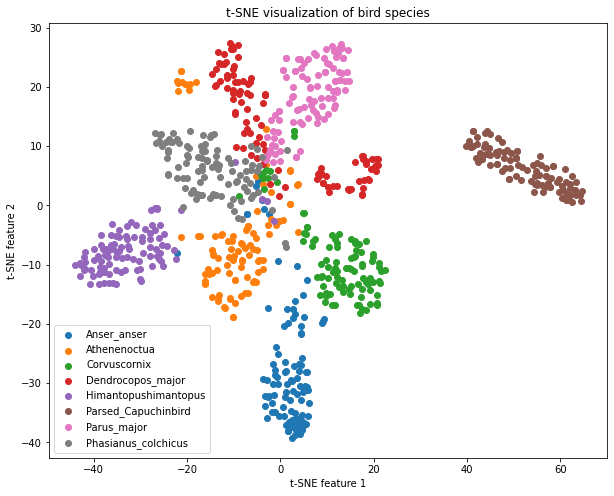

In [11]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.preprocessing import image
from sklearn.manifold import TSNE
# Path to the trained model

# Path to the trained model
model_path = 'bird_species_cnn_model_8genres_mel.h5'

# Load the trained model once
model = load_model(model_path)

def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(223, 217))  # Zaktualizuj rozmiar obrazu
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Skalowanie obrazu
    return img_array

# Extract features from the 'dense' layer (assuming this is the second to last layer)
layer_name = 'dense'  # Zaktualizuj nazwę warstwy w zależności od modelu
intermediate_layer_model = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)

# Function to extract features
def extract_features(img_path):
    img_array = preprocess_image(img_path)
    features = intermediate_layer_model.predict(img_array)
    return features.flatten()

# Paths to the spectrogram folders
# Paths to the spectrogram folders
# Paths to the spectrogram folders
base_dir = r'D:\sieci_neuronowe\projekt-sieci-neuronowe\mel_v2'
folders = ['Anser_anser', 'Dendrocopos_major', 'Parsed_Capuchinbird', 'Parus_major', 'Himantopushimantopus',  'Athenenoctua', 'Phasianus_colchicus', 'Corvuscornix']

results = {}
features = []
labels = []

for folder in folders:
    folder_path = os.path.join(base_dir, folder)
    spectrogram_files = os.listdir(folder_path)
    
    # Select 100 random spectrograms
    if len(spectrogram_files) < 100:
        print(f"Folder {folder} does not contain 100 images.")
        continue
    
    selected_files = random.sample(spectrogram_files, 100)
    
    for file in selected_files:
        spectrogram_path = os.path.join(folder_path, file)
        features.append(extract_features(spectrogram_path))
        labels.append(folder)

# Convert to numpy arrays
features = np.array(features)
labels = np.array(labels)

# Reduce dimensionality using t-SNE
tsne = TSNE(n_components=2, random_state=0)
features_2d = tsne.fit_transform(features)

# Plot t-SNE
plt.figure(figsize=(10, 8))
for species in np.unique(labels):
    indices = labels == species
    plt.scatter(features_2d[indices, 0], features_2d[indices, 1], label=species)

plt.legend()
plt.title('t-SNE visualization of bird species')
plt.xlabel('t-SNE feature 1')
plt.ylabel('t-SNE feature 2')
plt.show()
